In [1]:
from fbprophet import Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [2]:
sales_df = pd.read_csv('../prophet-quickstart/examples/example_retail_sales.csv',parse_dates=True)
df = sales_df.reset_index()
df=df.rename(columns={'date':'ds', 'sales':'y'})
df['y'] = np.log(df['y'])
model = Prophet()
model.fit(df);
future = model.make_future_dataframe(periods=24, freq = 'm')
forecast = model.predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sailyourlife/anaconda3/envs/nextopt/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [3]:
metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()

In [4]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,11.989275,11.854335,11.893692,11.989275,11.989275,-0.114717,-0.114717,-0.114717,-0.114717,-0.114717,-0.114717,0.0,0.0,0.0,11.874558
1,1992-02-01,11.995689,11.871536,11.911220,11.995689,11.995689,-0.104926,-0.104926,-0.104926,-0.104926,-0.104926,-0.104926,0.0,0.0,0.0,11.890763
2,1992-03-01,12.001690,11.991775,12.031305,12.001690,12.001690,0.009163,0.009163,0.009163,0.009163,0.009163,0.009163,0.0,0.0,0.0,12.010853
3,1992-04-01,12.008104,11.978134,12.019808,12.008104,12.008104,-0.009004,-0.009004,-0.009004,-0.009004,-0.009004,-0.009004,0.0,0.0,0.0,11.999100
4,1992-05-01,12.014312,12.035688,12.075249,12.014312,12.014312,0.040442,0.040442,0.040442,0.040442,0.040442,0.040442,0.0,0.0,0.0,12.054754


# 1. Metrics

In [5]:
metric_df.dropna(inplace=True)

In [6]:
print(r2_score(metric_df.y, metric_df.yhat))
print(mean_squared_error(metric_df.y, metric_df.yhat))
print(mean_absolute_error(metric_df.y, metric_df.yhat))

0.9972528925031164
0.00024193812021808074
0.012489430183972944


# 2. Forecasting Stock

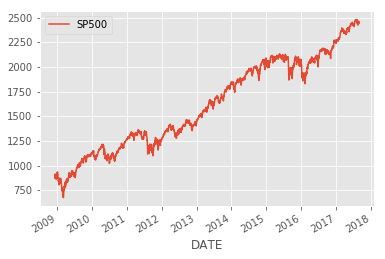

In [8]:
market_df = pd.read_csv('./SP500.csv', index_col='DATE', parse_dates=True)
market_df.plot()

In [9]:
market_df.head()

,SP500
DATE,
2017-08-30,2457.59
2017-08-29,2446.30
2017-08-28,2444.24
2017-08-25,2443.05
2017-08-24,2438.97


In [10]:
df = market_df.reset_index().rename(columns={'DATE':'ds', 'SP500':'y'})
df['y'] = np.log(df['y'])
model = Prophet()
model.fit(df);
future = model.make_future_dataframe(periods=365) #forecasting for 1 year from now.
forecast = model.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sailyourlife/anaconda3/envs/nextopt/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


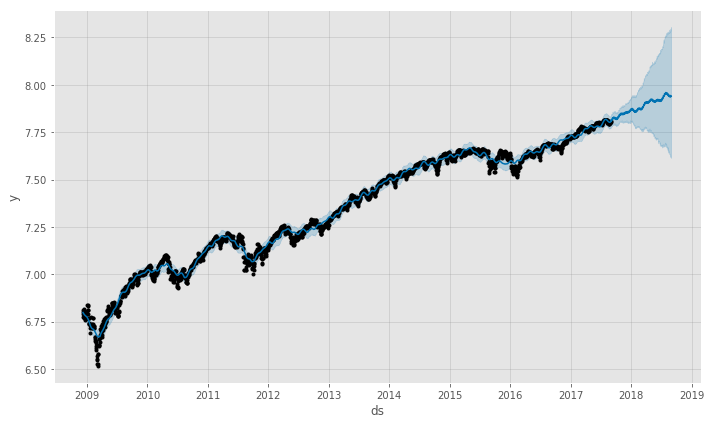

In [11]:
figure=model.plot(forecast)

### 기존 예측

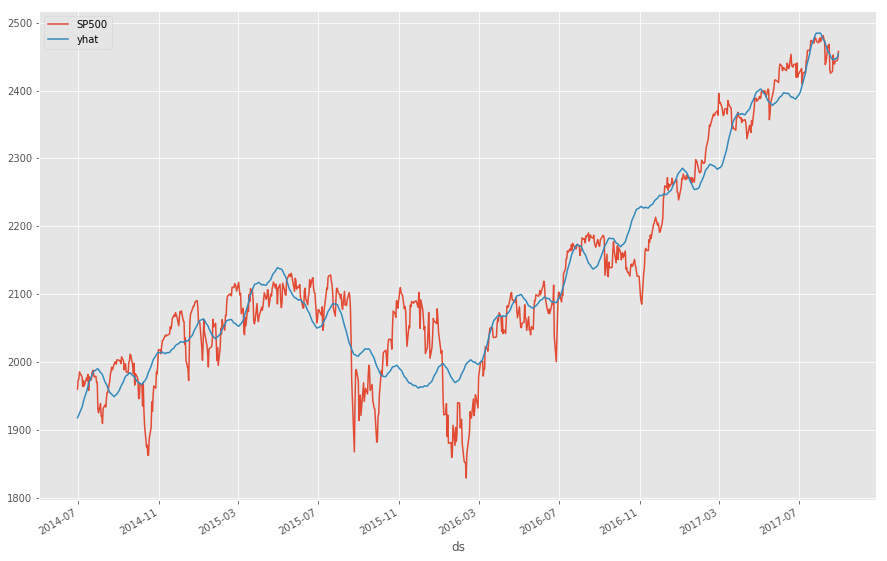

In [13]:
two_years = forecast.set_index('ds').join(market_df)
two_years = two_years[['SP500', 'yhat', 'yhat_upper', 'yhat_lower' ]].dropna().tail(800)
two_years['yhat']=np.exp(two_years.yhat)
two_years['yhat_upper']=np.exp(two_years.yhat_upper)
two_years['yhat_lower']=np.exp(two_years.yhat_lower)
two_years[['SP500', 'yhat']].plot(figsize=(15,10))

In [14]:
two_years_AE = (two_years.yhat - two_years.SP500)
two_years_AE.describe()

count    800.000000
mean      -0.684251
std       47.467245
min     -141.012928
25%      -28.965822
50%       -1.141530
75%       25.464284
max      168.351114
dtype: float64

In [15]:
r2_score(two_years.SP500, two_years.yhat)

0.9060291571995387

In [16]:
mean_squared_error(two_years.SP500, two_years.yhat)

2250.7911275602214

In [17]:
mean_absolute_error(two_years.SP500, two_years.yhat)

35.99447733357443

- linestyle

Text(0.5,0,'Date')

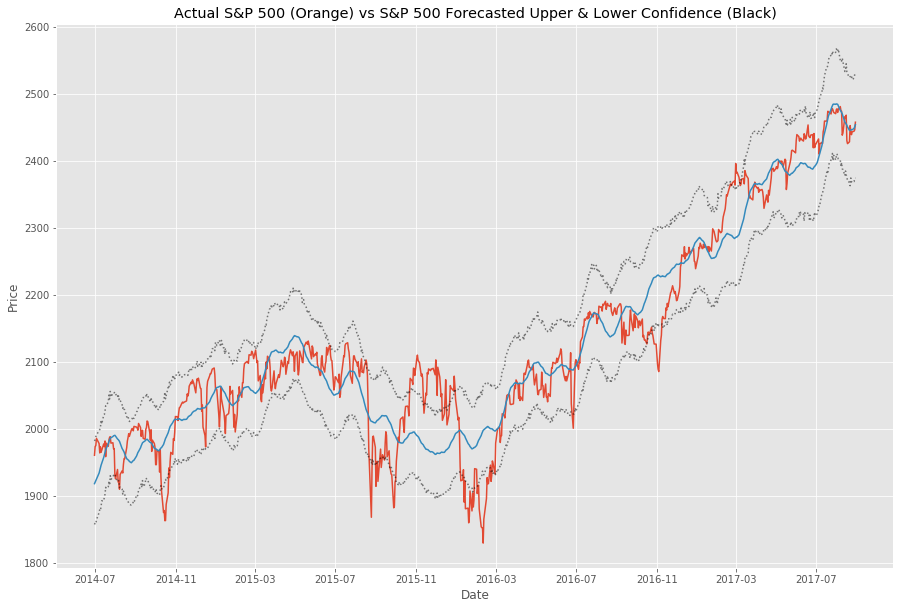

In [24]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(two_years.SP500)
ax1.plot(two_years.yhat)
ax1.plot(two_years.yhat_upper, color='black',  linestyle=':', alpha=0.5)
ax1.plot(two_years.yhat_lower, color='black',  linestyle=':', alpha=0.5)

ax1.set_title('Actual S&P 500 (Orange) vs S&P 500 Forecasted Upper & Lower Confidence (Black)')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

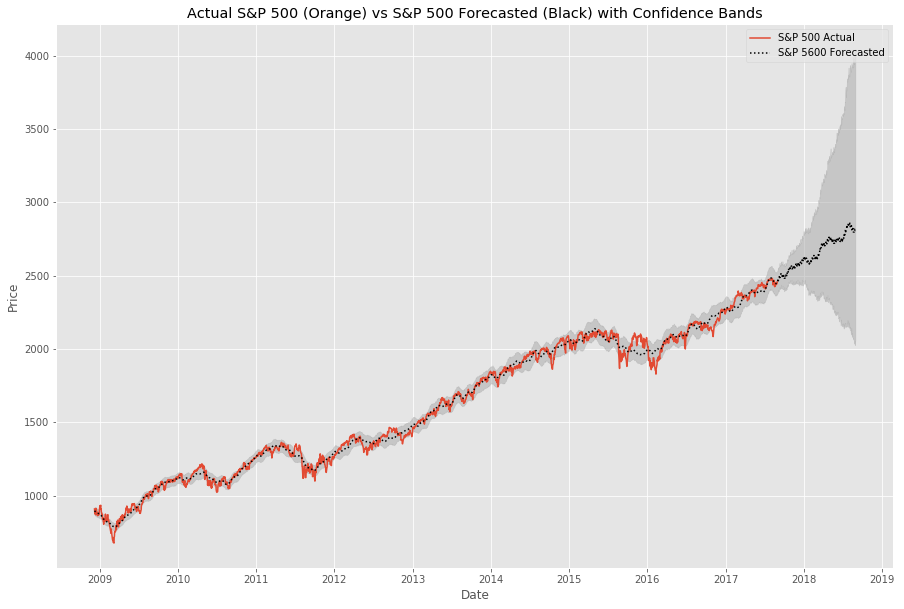

In [25]:
full_df = forecast.set_index('ds').join(market_df)
full_df['yhat']=np.exp(full_df['yhat'])

fig, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(full_df.SP500)
ax1.plot(full_df.yhat, color='black', linestyle=':')
ax1.fill_between(full_df.index, np.exp(full_df['yhat_upper']), np.exp(full_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('Actual S&P 500 (Orange) vs S&P 500 Forecasted (Black) with Confidence Bands')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('S&P 500 Actual') #change the legend text for 1st plot
L.get_texts()[1].set_text('S&P 5600 Forecasted') #change the legend text for 2nd plot

# 3. Trend Changepoint

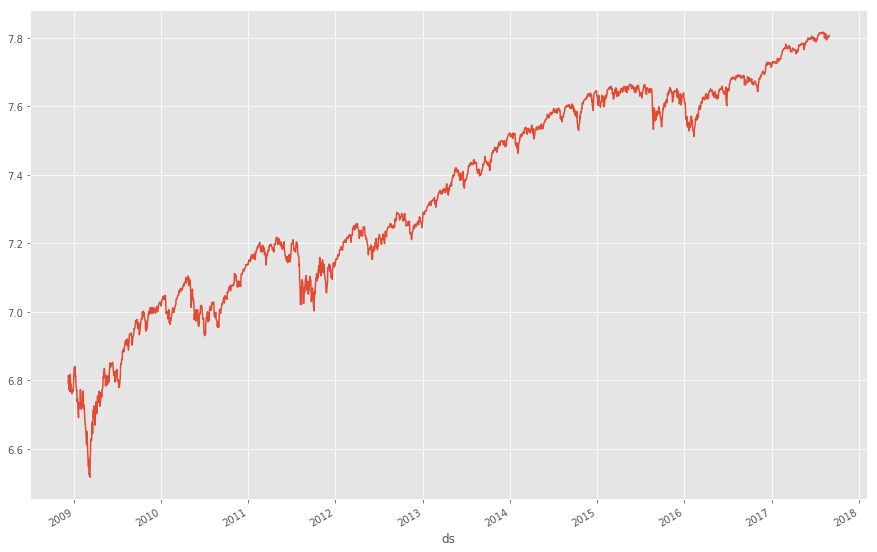

In [27]:
market_df = pd.read_csv('./SP500.csv', index_col='DATE', parse_dates=True)
df = market_df.reset_index().rename(columns={'DATE':'ds', 'SP500':'y'})
df['y'] = np.log(df['y'])

#lets take a look at our data quickly
df.set_index('ds').y.plot(figsize=(15,10))

In [28]:
model = Prophet()
model.fit(df);
future = model.make_future_dataframe(periods=366)
forecast = model.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sailyourlife/anaconda3/envs/nextopt/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [29]:
model.changepoints

70     2009-03-20
141    2009-07-01
211    2009-10-09
281    2010-01-21
351    2010-05-03
422    2010-08-12
492    2010-11-19
562    2011-03-03
633    2011-06-14
703    2011-09-22
773    2012-01-03
843    2012-04-13
914    2012-07-25
984    2012-11-05
1054   2013-02-15
1124   2013-05-29
1195   2013-09-09
1265   2013-12-17
1335   2014-03-31
1406   2014-07-11
1476   2014-10-20
1546   2015-01-30
1616   2015-05-12
1687   2015-08-21
1757   2015-12-01
Name: ds, dtype: datetime64[ns]

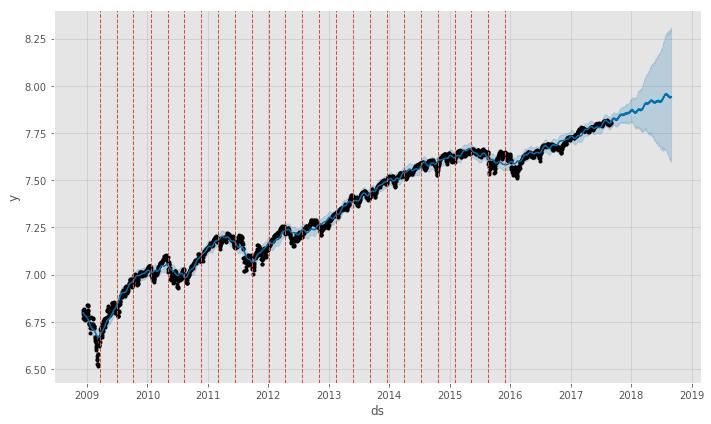

In [30]:
figure = model.plot(forecast)
for changepoint in model.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)

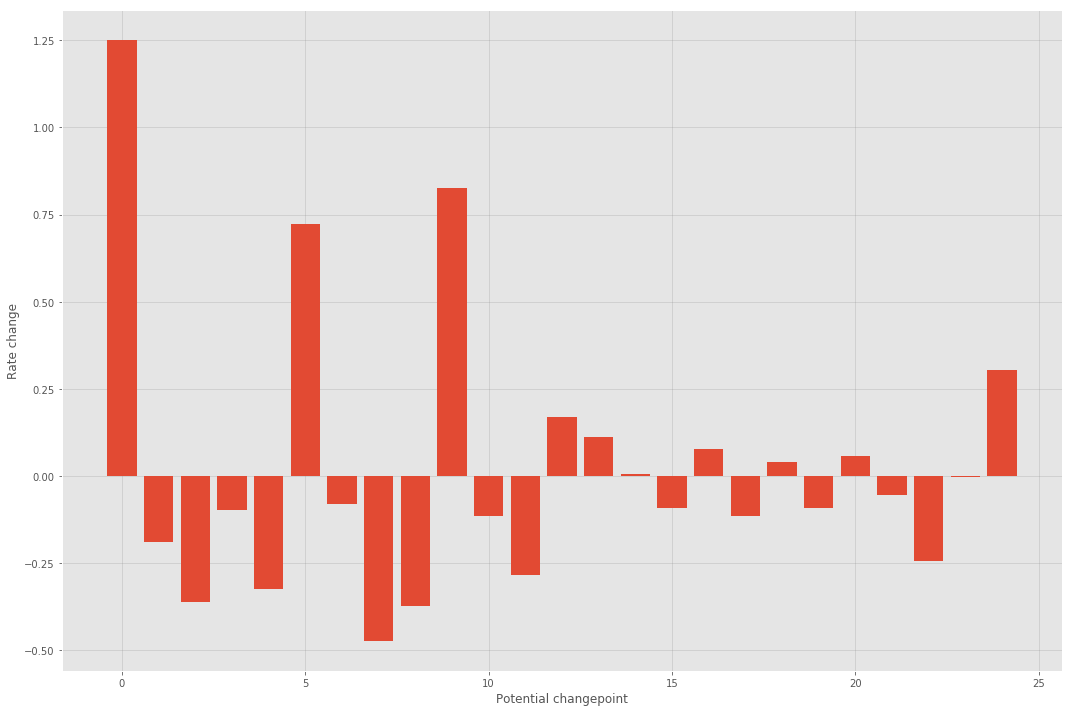

In [32]:
deltas = model.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(15,10))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sailyourlife/anaconda3/envs/nextopt/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


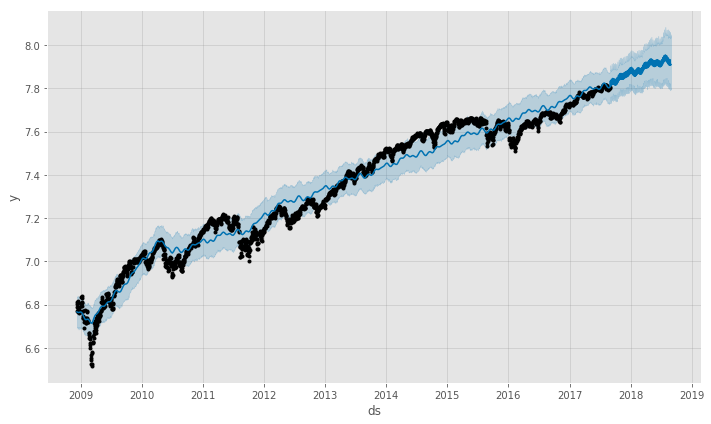

In [33]:
m = Prophet(changepoints=['2009-03-09', '2010-07-02', '2011-09-26', '2012-03-20', '2010-04-06'])
forecast = m.fit(df).predict(future)
m.plot(forecast);

In [34]:
m.changepoints

DatetimeIndex(['2009-03-09', '2010-07-02', '2011-09-26', '2012-03-20',
               '2010-04-06'],
              dtype='datetime64[ns]', freq=None)